<a href="https://colab.research.google.com/github/AsalNouri/Fall-2020/blob/master/Brain_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/williamedwardhahn/mpcr
!pip install flashtorch
!pip install barbar
from mpcr import *
from flashtorch.utils import apply_transforms
from flashtorch.saliency import Backprop
import itertools
from sklearn.metrics import confusion_matrix

  Cloning https://github.com/williamedwardhahn/mpcr to /tmp/pip-req-build-4ydz5tgo
  Running command git clone -q https://github.com/williamedwardhahn/mpcr /tmp/pip-req-build-4ydz5tgo
  Created wheel for ImportMPCR: filename=ImportMPCR-0.0.1-cp37-none-any.whl size=7332 sha256=d3b799a1bc6f639563e4d930a3d37d6fd85f35b8d78b020b68d381555c67e9b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-cbg9uad7/wheels/89/93/47/ef43fe80a5b823a05d8dcca5ed1581f4fcdacf69b27110603f
Successfully built ImportMPCR
  Created wheel for flashtorch: filename=flashtorch-0.1.3-cp37-none-any.whl size=26249 sha256=bbcd8fc7d60f2f8f9170ecd8aa6ad8fc19998295c66def6b36943b7656e2a79a
  Stored in directory: /root/.cache/pip/wheels/03/6d/b1/2d3c5987b69e900fcceceeef39d3ed92dfe46ba1359b9c79f8
Successfully built flashtorch
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create new folder on your google drive like below:

In [ ]:
data_dir = '/content/drive/MyDrive/Dataset1 /Brains'

In [ ]:
os.chdir(data_dir)

In [ ]:
dataset_labels =["Healthy", "Tumor"] #<--- Replace with your labels 

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  #Data Augmentation 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [ ]:
batch_size = 16
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
dataset_sizes

{'train': 80, 'valid': 20}

In [ ]:
def imshow(inp, title = " "):
    fig, ax = plt.subplots()
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    plt.title(title, loc='center')
    # fig.set_size_inches(5, 5)
    plt.show()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


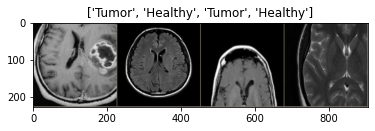

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[7:11]
classes = classes[7:11] 
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[dataset_labels[x] for x in classes])

In [ ]:
inputs.shape

torch.Size([4, 3, 224, 224])

In [ ]:
def train_model(model, num_epochs=25):

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):

        print('Epoch: ',epoch+1,'/',num_epochs)

        ###Train
        model.train() 
        running_corrects = 0
        for inputs, labels in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print("Train ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['train']))
        
        scheduler.step()
    
        ###Val
        model.eval()  
        running_corrects = 0
        for inputs, labels in dataloaders['valid']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = torch.max(outputs, 1)[1]
            running_corrects += torch.sum(preds == labels.data)

        print("Valid ", 'Acc: {:.2f}'.format(running_corrects.double()/dataset_sizes['valid']))
        print("#######################")
    return model

In [ ]:
model = models.resnet18(pretrained=True)

In [ ]:
model.conv1 

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [ ]:
# model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) #change first layer to single channel inputs

In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)

In [ ]:
model = train_model(model, num_epochs=30)

Epoch:  1 / 30


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train  Acc: 0.12
Valid  Acc: 0.55
#######################
Epoch:  2 / 30
Train  Acc: 0.49
Valid  Acc: 0.70
#######################
Epoch:  3 / 30
Train  Acc: 0.62
Valid  Acc: 0.55
#######################
Epoch:  4 / 30
Train  Acc: 0.83
Valid  Acc: 0.70
#######################
Epoch:  5 / 30
Train  Acc: 0.84
Valid  Acc: 0.75
#######################
Epoch:  6 / 30
Train  Acc: 0.95
Valid  Acc: 0.80
#######################
Epoch:  7 / 30
Train  Acc: 0.94
Valid  Acc: 0.85
#######################
Epoch:  8 / 30
Train  Acc: 0.88
Valid  Acc: 0.85
#######################
Epoch:  9 / 30
Train  Acc: 0.90
Valid  Acc: 0.85
#######################
Epoch:  10 / 30
Train  Acc: 0.93
Valid  Acc: 0.85
#######################
Epoch:  11 / 30
Train  Acc: 0.95
Valid  Acc: 0.80
#######################
Epoch:  12 / 30
Train  Acc: 0.86
Valid  Acc: 0.75
#######################
Epoch:  13 / 30
Train  Acc: 0.96
Valid  Acc: 0.75
#######################
Epoch:  14 / 30
Train  Acc: 0.93
Valid  Acc: 0.80
############

In [ ]:
def visualize_model(model, num_images=16):
    model.eval()
    index = 0
    True_positive =0
    True_negative = 0
    for i, (inputs, labels) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        preds = torch.max(outputs, 1)[1]

        for j in range(inputs.size()[0]):
            index += 1
            title1 = 'predicted: ' + dataset_labels[preds[j]] + '     class: ' + dataset_labels[labels[j]]
            
            imshow(inputs.cpu().data[j],title1)

            if dataset_labels[labels[j]]== "Tumor":
              True_positive += dataset_labels[preds[j]]== dataset_labels[labels[j]]
            if dataset_labels[labels[j]] == "Healthy":
              True_negative += dataset_labels[preds[j]]== dataset_labels[labels[j]]



            if index == num_images:
                return True_positive, True_negative

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


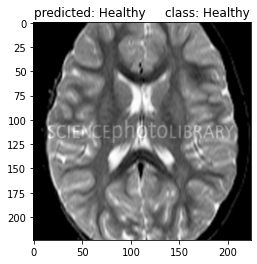

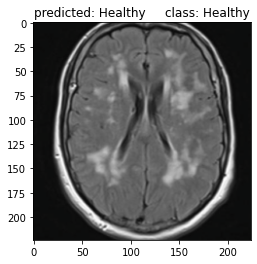

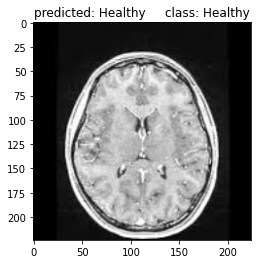

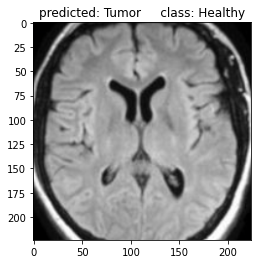

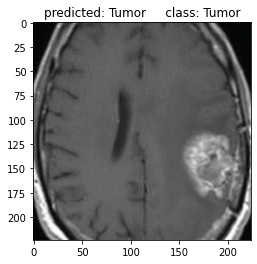

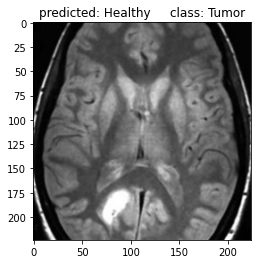

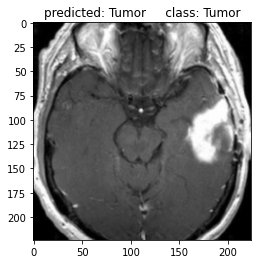

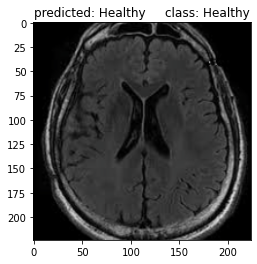

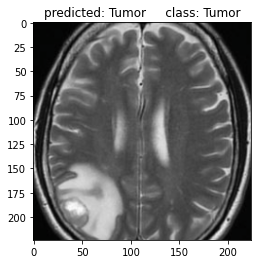

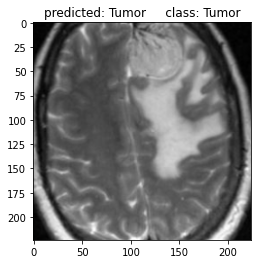

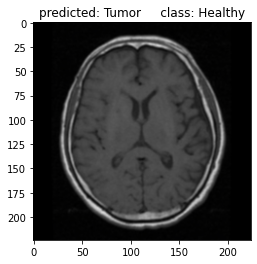

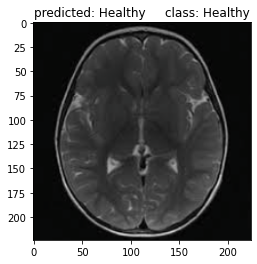

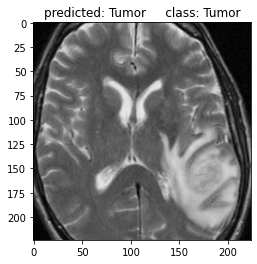

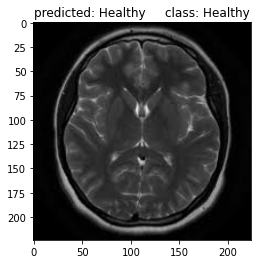

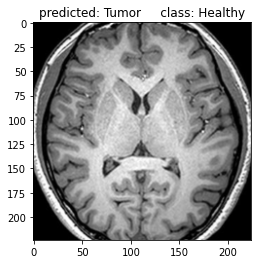

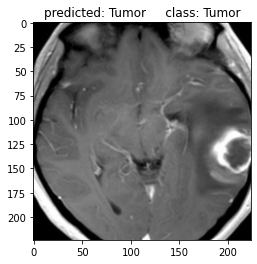

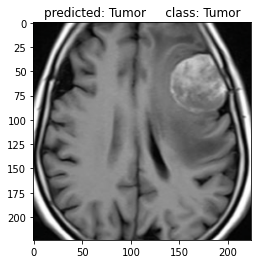

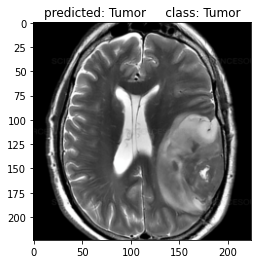

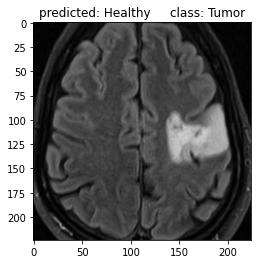

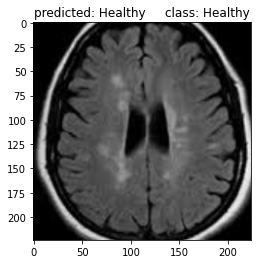

8 7


In [ ]:
TP, TN = visualize_model(model,20) #sample images to show accuracy of prediction
print(TP, TN)

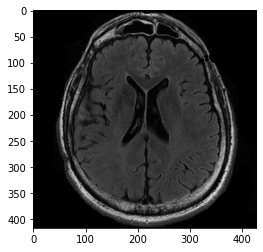

In [ ]:
image = io.imread('https://www.brainline.org/sites/default/files/migrated//FLAIR.jpg')
plt.imshow(image);

In [ ]:
img = apply_transforms(image).clone().detach().requires_grad_(True).to(device)

In [ ]:
outputs = model(img)
preds = torch.max(outputs, 1)[1]

In [ ]:
print('predicted: ' + dataset_labels[preds])

predicted: Healthy


In [ ]:
batch_size = 1024 #large batch size so we test all the data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
inputs,labels = next(iter(dataloaders['valid']))
inputs = inputs.to(device)
labels = labels.detach().cpu().numpy()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
outputs = model(inputs)
preds = torch.max(outputs, 1)[1].detach().cpu().numpy()

In [ ]:
cm = confusion_matrix(preds.reshape(-1),labels)

In [ ]:
print("Confusion Matrix : ")
cm

Confusion Matrix : 


array([[7, 2],
       [3, 8]])

In [ ]:
cm[0,0] #True Negative

7

In [ ]:
cm[1,1] #True Positive

8

In [ ]:
cm[0,1] #False Positive

2

In [ ]:
cm[1,0] #False Negative

3

In [ ]:
accuracy = (cm[0,0]+ cm[1,1])/20 # Accuracy
print(accuracy)

0.75


In [ ]:
precision = cm[1,1]/10  #Precision
print(precision)

0.8


In [ ]:
recall = cm[1,1]/(cm[1,1]+ cm[1,0]) #recall 
print(recall)

0.7272727272727273


In [ ]:
F_measure =(2*precision*recall)/(precision+recall)
print(F_measure)

0.761904761904762
